# Supplementary Fig. 8a: Chromosome fusions in *Xenopus laevis* and *Hymenochirus boettgeri*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import pysam
import datetime
import matplotlib as mpl
import matplotlib.cm as cm
import re
import os

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

%matplotlib inline 

Mb= 1000000
min_num_reads  = 15
min_z_score    = 4

colors_dict = {0:'red',1:'gray',2:'green',3:'black',4:'blue',5:'purple', 6:'orange',7:'brown'}

source_data_path = 'SourceData'
sup_fig_8      = 'Supplementary_Fig.8'

Specie_id      = 'XL9_2'
Specie_name    = 'Xlaevis'
chr_index      = os.path.join(source_data_path, sup_fig_8, sup_fig_8+'a', Specie_id+'.chrom.sizes')
out_dir        = os.path.join(source_data_path, sup_fig_8, sup_fig_8+'a')

chr_sizes           = pd.read_csv(chr_index, names=['Chr','Length'], sep='\t')
chr_sizes           = chr_sizes[chr_sizes.Chr.str.startswith('Chr')]
ordered_chromosomes = natural_sort(copy.copy(chr_sizes.Chr.unique()))


bio-mpl/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


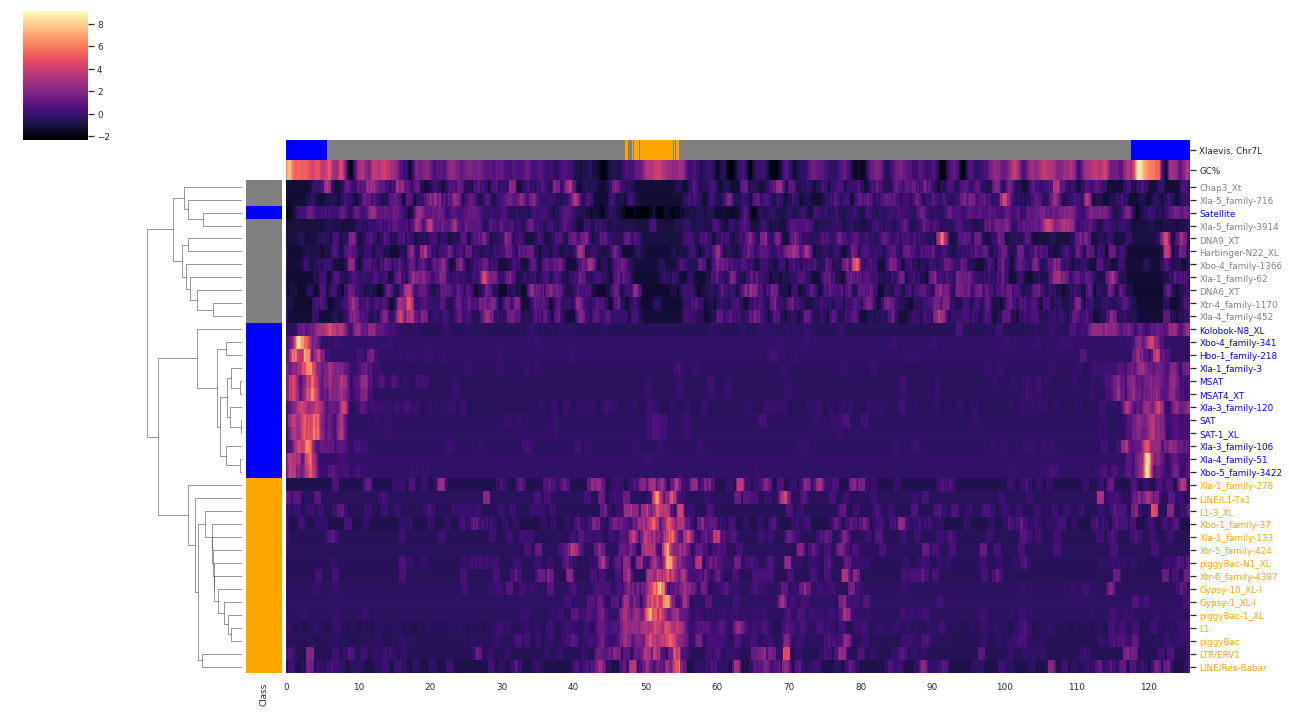

bio-mpl/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


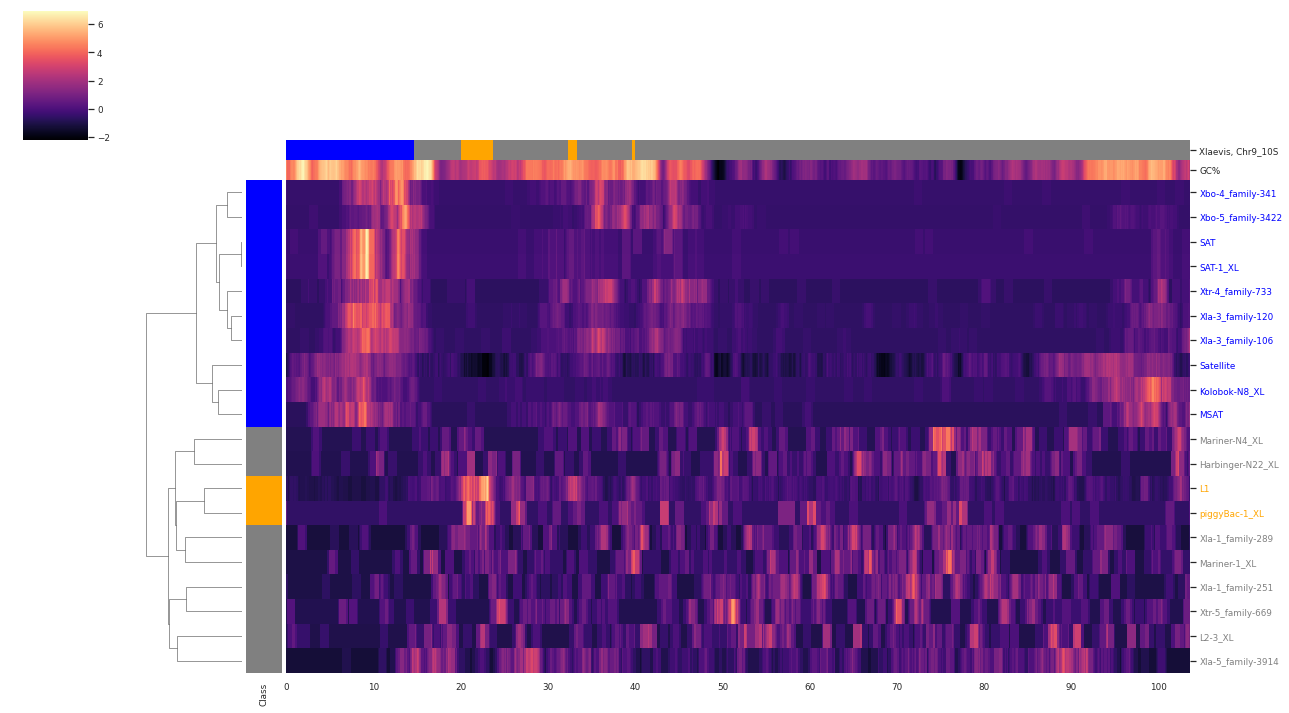

In [4]:
import json

colors_dict_ = {'arm':'gray','Telomere':'blue','Centromere':'orange'}
sns.set(font_scale=.8, context='notebook', style='white')

color_chosen ='magma'


def draw_clustermap(Chr_, Specie_name):
    #plt.figure(figsize=(20,8))
    Region_to_display = 'Region'
    min_z_score =3
    min_num_reads =50

    Xtropicalis_repeat_Class_and_GC = pd.read_csv(os.path.join(source_data_path, sup_fig_8, sup_fig_8+'a', sup_fig_8+'a_'+Chr_+'.tsv'), sep="\t")
    with open(os.path.join(source_data_path, sup_fig_8, sup_fig_8+'a', sup_fig_8+'a_'+Chr_+'.json'), 'r') as f:
        CaT_reps = json.load(f)
    cen_reps = CaT_reps['Centromere']
    tel_reps = CaT_reps['Telomere']
    arm_reps = CaT_reps['arm']
    Rep_to_plot = list(set(cen_reps+ tel_reps + arm_reps))
    
    Chr1_pad = copy.copy(Xtropicalis_repeat_Class_and_GC[['Start']+Rep_to_plot])

    Chr1_pad['position'] = (Chr1_pad.Start/Mb).astype(int)
    Chr1_pad = Chr1_pad[Rep_to_plot].T
    Chr1_pad = Chr1_pad[Chr1_pad.T.sum()>min_num_reads]
    title= ', '.join((Specie_name, Chr_))
    variable_reps = Chr1_pad.T.sum()[Chr1_pad.T.sum()>10].index.tolist()
    norm = mpl.colors.Normalize(vmin=Xtropicalis_repeat_Class_and_GC[Xtropicalis_repeat_Class_and_GC['Chr']==Chr_]['GC%'].min(), vmax=Xtropicalis_repeat_Class_and_GC[Xtropicalis_repeat_Class_and_GC['Chr']==Chr_]['GC%'].max())
    
    cmap = cm.get_cmap(color_chosen)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    GC_content  = m.to_rgba(Xtropicalis_repeat_Class_and_GC[Xtropicalis_repeat_Class_and_GC['Chr']==Chr_]['GC%'])
    Chr_region  = Xtropicalis_repeat_Class_and_GC[Xtropicalis_repeat_Class_and_GC.Chr==Chr_][Region_to_display].map(colors_dict_).tolist()
    
    row_colors_multiple = pd.DataFrame({title : Xtropicalis_repeat_Class_and_GC[Xtropicalis_repeat_Class_and_GC.Chr==Chr_][Region_to_display].map(colors_dict_).tolist(),
                                   'GC%': m.to_rgba(Xtropicalis_repeat_Class_and_GC[Xtropicalis_repeat_Class_and_GC['Chr']==Chr_]['GC%']).tolist()})
    
    Colors_reps = pd.DataFrame.from_dict(dict(zip(arm_reps + cen_reps + tel_reps, ['gray']*len(arm_reps) + ['orange']*len(cen_reps) + ['blue']*len(tel_reps))), orient='index')
    Colors_reps = Colors_reps.rename(columns={0:'Class'})
    Colors_reps = Colors_reps.loc[Rep_to_plot]
    
    g = sns.clustermap(Chr1_pad, row_cluster=True,  col_cluster=False, annot_kws={"size": 3}, figsize=(18,10), xticklabels=True, method='average',  metric='correlation', col_colors=row_colors_multiple, row_colors=Colors_reps['Class'] , cmap=color_chosen, z_score=0)
    g.ax_row_dendrogram.set_xlim([3,0])
    
    for tick_label in g.ax_heatmap.axes.get_yticklabels():
        tick_label.set_color(Colors_reps.loc[tick_label.get_text()].Class)
    
    Chr_pos = copy.copy(Xtropicalis_repeat_Class_and_GC[Xtropicalis_repeat_Class_and_GC.Chr==Chr_][['Start']])
    Chr_pos['Mb'] = Chr_pos.Start.apply(lambda x: x//Mb if np.mod(x,10*Mb)==0 else '')
    g.ax_heatmap.axes.set_xticklabels(Chr_pos['Mb'])
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0)
    figure_name = os.path.join(out_dir,Specie_id+'_'+Chr_+'_Density_heatmap.png')
    plt.savefig(figure_name, dpi=200)
    plt.show()
    

for Chr_ in ordered_chromosomes:
    draw_clustermap(Chr_, Specie_name)